<h1>Define headers</h1>

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

# import some common libraries
import numpy as np
import cv2
import random
import os
import json
import time
import statistics 
import math  

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

from PIL import Image

import torch
torch.cuda.set_device(0)

<h1> Define Dataset</h1>

In [2]:
def get_ball_dicts():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4:69+4]
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
            x = line_label.split()
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

def get_ball_dicts_grayscale():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images_grayscale.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4+1:69+4+1]
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
            x = line_label.split()
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("Ball_train", lambda:get_ball_dicts())
MetadataCatalog.get("Ball_train").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train")


DatasetCatalog.register("Ball_train_bw", lambda:get_ball_dicts_grayscale())
MetadataCatalog.get("Ball_train_bw").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train_bw")

<h1>Confirm if datasets works</h1>

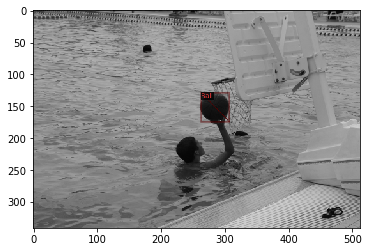

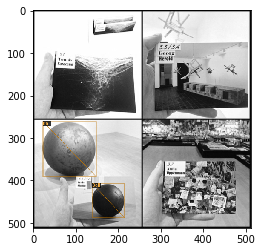

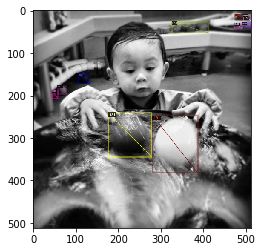

In [3]:
import random 
import matplotlib.pyplot as plt
dataset_dicts = get_ball_dicts_grayscale()
ball_metadata = MetadataCatalog.get("Ball_train_bw")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ball_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image()[:, :, ::-1])
    


In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("Ball_train_bw",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 7000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[02/14 07:30:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[02/14 07:30:13 d2.data.build]: Removed 0 images with no usable annotations. 3480 images left.
[02/14 07:30:13 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    Ball    | 6845         |
|            |              |
[02/14 07:30:13 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/14 07:30:13 d2.data.build]: Using training sampler TrainingSampler
[02/14 07:30:23 d2.engine.train_loop]: Starting training from iteration 7000
[02/14 07:30:23 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


OrderedDict()

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ball_train", )
predictor = DefaultPredictor(cfg)

In [6]:
cameraMatrix_IR=np.array([[705.1735, 0.000000, 172.6855],
                          [0.000000, 710.7784, 148.5702],
                          [0.000000, 0.000000, 1.000000]])
cameraMatrix_rgb_pointgrey=np.array([[1152.437560398629, 0, 478.3335229505631], 
                                    [0, 1155.693500473246, 351.508630859905], 
                                    [0, 0, 1]])
cameraMatrix_mono=np.array([[2363.738690444174,0,1072.79004424623],
[0,2370.592662770868, 788.4498446284557],
[0,0,1]])

fx_mono=cameraMatrix_mono[0][0]
fy_mono=cameraMatrix_mono[1][1]
cx_mono=cameraMatrix_mono[0][2]
cy_mono=cameraMatrix_mono[1][2]

fx_ir=cameraMatrix_IR[0][0]
fy_ir=cameraMatrix_IR[1][1]
cx_ir=cameraMatrix_IR[0][2]
cy_ir=cameraMatrix_IR[1][2]

fx_rgb=cameraMatrix_rgb_pointgrey[0][0]
fy_rgb=cameraMatrix_rgb_pointgrey[1][1]
cx_rgb=cameraMatrix_rgb_pointgrey[0][2]
cy_rgb=cameraMatrix_rgb_pointgrey[1][2]
print(fx_rgb,fy_rgb,cx_rgb,cy_rgb)

d_real=0.63 *1000#mm


1152.437560398629 1155.693500473246 478.3335229505631 351.508630859905


<h1> Plot 3D real points </h1>

In [7]:
#read txt files with image path
# txt_file_rgb =os.path.join("/home/danielarato/ball_detection/Datasets/train/3cams/", "3cams_RGB.txt")
# f_rgb = open(txt_file_rgb, "r")

txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/compilation/", "compilation_IR.txt")
f_ir = open(txt_file_ir, "r")

txt_file_mono =os.path.join("/home/danielarato/ball_detection/Datasets/train/compilation/", "compilation_RGB.txt")
f_mono = open(txt_file_mono, "r")

#initiate vectors
xpi=[]
ypi=[]
xpm=[]
ypm=[]
dm=[]
di=[]
c=0
c_for=0

#for each figure in the path
for line_mono in f_mono: 
    c_for+=1
    # read images and calculate detected bounding box for each camera    
    line_ir=f_ir.readline()
    if(line_ir==""):
        break
    im_ir = cv2.imread(line_ir[:len(line_ir)-1])
    outputs_ir = predictor(im_ir)
    results_ir=outputs_ir["instances"].to("cpu")
    
    im_mono = cv2.imread(line_mono[:len(line_mono)-1])
    outputs_mono = predictor(im_mono)
    results_mono=outputs_mono["instances"].to("cpu")

    # CALCULATE CENTERS - remove images without detection in both timestamp
    if(len(results_ir)!=0 and len(results_mono)!=0):
        coordinates_ir=results_ir.pred_boxes.tensor[0].numpy()
        coordinates_mono=results_mono.pred_boxes.tensor[0].numpy()

        cond2=(abs((coordinates_ir[2]-coordinates_ir[0])-(coordinates_ir[3]-coordinates_ir[1]))>=0.07*max((coordinates_ir[2]-coordinates_ir[0]),(coordinates_ir[3]-coordinates_ir[1])))
        cond3=(abs((coordinates_mono[2]-coordinates_mono[0])-(coordinates_mono[3]-coordinates_mono[1]))>=0.07*max((coordinates_mono[2]-coordinates_mono[0]),(coordinates_mono[3]-coordinates_mono[1])))
        
        if(cond2==False and cond3==False):
            #IR
            xc_ir=(coordinates_ir[2]-coordinates_ir[0])/2+coordinates_ir[0]
            yc_ir=(coordinates_ir[3]-coordinates_ir[1])/2+coordinates_ir[1]
            xc_ir=float("%0.2f"%xc_ir)
            yc_ir=float("%0.2f"%yc_ir)

            dx_ir=float("%0.2f"%(float("%0.2f"%coordinates_ir[2])-float("%0.2f"%coordinates_ir[0])))
            dy_ir=float("%0.2f"%(float("%0.2f"%coordinates_ir[3])-float("%0.2f"%coordinates_ir[1])))
            d_pix_ir=(dx_ir+dy_ir)/2

            #mono
            xc_mono=(coordinates_mono[2]-coordinates_mono[0])/2+coordinates_mono[0]
            yc_mono=(coordinates_mono[3]-coordinates_mono[1])/2+coordinates_mono[1]
            xc_mono=float("%0.2f"%xc_mono)
            yc_mono=float("%0.2f"%yc_mono)

            dx_mono=float("%0.2f"%(float("%0.2f"%coordinates_mono[2])-float("%0.2f"%coordinates_mono[0])))
            dy_mono=float("%0.2f"%(float("%0.2f"%coordinates_mono[3])-float("%0.2f"%coordinates_mono[1])))
            d_pix_mono=(dx_mono+dy_mono)/2


            #append points
            xpi.append(xc_ir)
            ypi.append(yc_ir)
            xpm.append(xc_mono)
            ypm.append(yc_mono)
            dm.append(d_pix_mono)
            di.append(d_pix_ir)
            
            c+=1
            
f_ir.close()        
f_mono.close()
print(c,c_for)

207 455


In [30]:
def find_optimal_fraction(fx,fy,d_pix):
    d_real=630
    dst=1000
    frac=1
    Z=((fx+fy)/2)*(d_real/d_pix)
    d=Z
    while (dst>0.01):
        frac=d/(d+(d_real/2))
        d_1=((fx+fy)/2)*(d_real*frac/d_pix)-d_real/2-(d_real/2)*math.cos(math.asin((frac)))
        dst=(d-d_1)/d_1
        d=d_1
#     print(frac)
    return frac

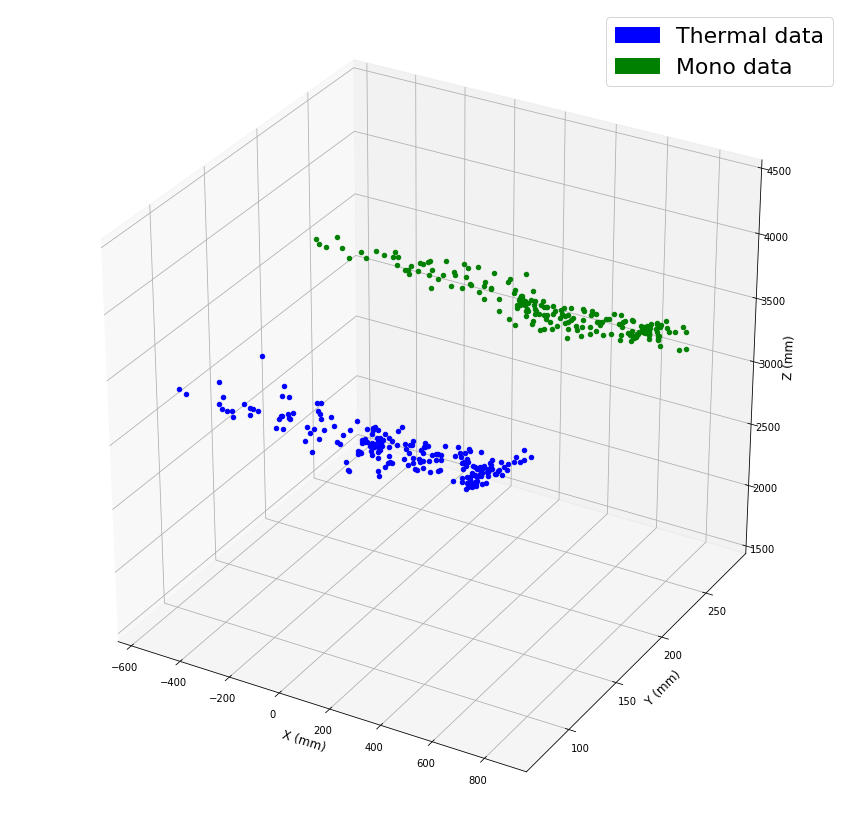

In [31]:
Xt=[]
Yt=[]
Zt=[]
Xm=[]
Ym=[]
Zm=[]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d' )
black_patch = mpatches.Patch(color='green', label='Mono data')
red_patch = mpatches.Patch(color='blue', label='Thermal data')
plt.legend(handles=[red_patch,black_patch],fontsize=22)


ax.set_xlabel('X (mm)',fontsize=12)
ax.set_ylabel('Y (mm)',fontsize=12)
ax.set_zlabel('Z (mm)',fontsize=12)
ax.set_zlim(1500,4500)


for n in range(0,len(xpi)):
    frac=find_optimal_fraction(fx_ir,fy_ir,di[n])
    Z_ir=((fx_ir+fy_ir)/2)*(d_real*frac/di[n])+(d_real/2)*math.cos(math.asin((frac)))
    X_ir=(Z_ir*(xpi[n]-cx_ir))/fx_ir
    Y_ir=(Z_ir*(ypi[n]-cy_ir))/fy_ir
    
    frac=find_optimal_fraction(fx_mono,fy_mono,dm[n])
    Z_mono=((fx_mono+fy_mono)/2)*(d_real*frac/dm[n])+(d_real/2)*math.cos(math.asin((frac)/2))
    X_mono=(Z_mono*(xpm[n]-cx_mono))/fx_mono
    Y_mono=(Z_mono*(ypm[n]-cy_mono))/fy_mono
    if (Z_ir<30000):
        Xt.append(X_ir)
        Yt.append(Y_ir)
        Zt.append(Z_ir) 
        Xm.append(X_mono)
        Ym.append(Y_mono)
        Zm.append(Z_mono) 

        ax.scatter(X_ir, Y_ir, Z_ir, c='b')
        ax.scatter(X_mono, Y_mono, Z_mono, c='green')
# print(Zm)
    

In [32]:
frac

0.8938802860323061

<h1>Plot pixel points vs real distance to ball</h1>

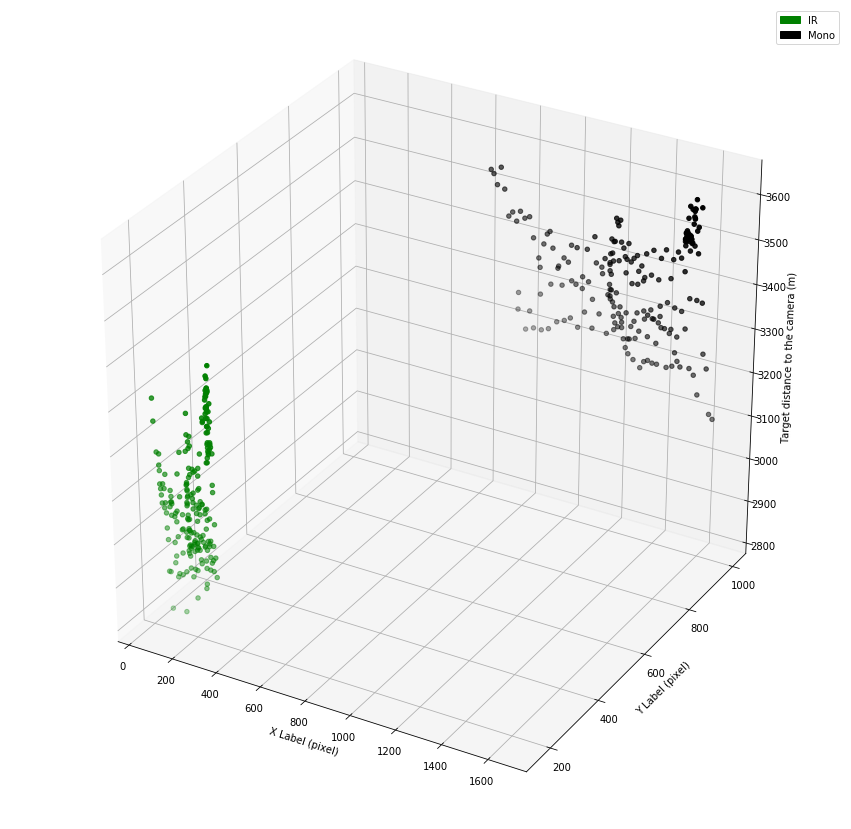

In [33]:
fig3 = plt.figure(figsize=(15,15))
ax3 = fig3.add_subplot(111, projection='3d' )
blue_patch = mpatches.Patch(color='green', label='IR')
black_patch = mpatches.Patch(color='black', label='Mono')

plt.legend(handles=[blue_patch,black_patch])
ax3.set_xlabel('X Label (pixel)')
ax3.set_ylabel('Y Label (pixel)')
ax3.set_zlabel('Target distance to the camera (m)')

ax3.scatter(xpi,ypi,Zt, c='g')
ax3.scatter(xpm,ypm,Zm, c='k')
# print(xpi)
# print(xpr)
# im_rgb.shape

<h1>Plot Ball Center in Pixels</h1>

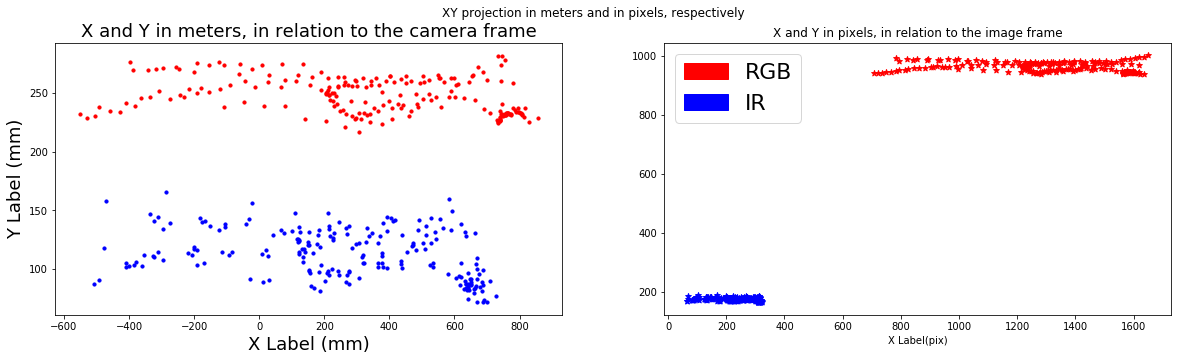

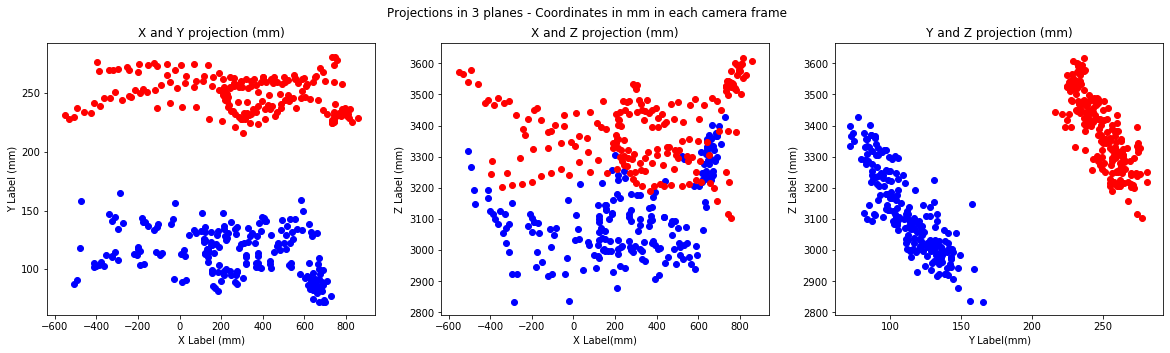

In [34]:
fig0, axs_0 = plt.subplots(1,2,figsize=(20,5))
blue_patch = mpatches.Patch(color='blue', label='IR')
red_patch = mpatches.Patch(color='red', label='RGB')
plt.legend(handles=[red_patch,blue_patch],fontsize=22,loc=2)

fig0.suptitle("XY projection in meters and in pixels, respectively ")

axs_0[0].scatter(Xt,Yt,c='b',s=10)
axs_0[0].scatter(Xm,Ym,c='r',s=10)
axs_0[0].set_xlabel('X Label (mm)',fontsize=18)
axs_0[0].set_ylabel('Y Label (mm)',fontsize=18)
axs_0[0].set_title('X and Y in meters, in relation to the camera frame',fontsize=18)

axs_0[1].scatter(xpi,ypi,c='b',marker="*")
axs_0[1].scatter(xpm,ypm,c='r',marker="*")
axs_0[1].set_xlabel('X Label(pix)')
axs_0[1].set_title('X and Y in pixels, in relation to the image frame')

fig_proj, axs_proj = plt.subplots(1,3,figsize=(20,5))

fig_proj.suptitle("Projections in 3 planes - Coordinates in mm in each camera frame")

axs_proj[0].scatter(Xt,Yt, c='b')
axs_proj[0].scatter(Xm,Ym, c='r')
axs_proj[0].set_xlabel('X Label (mm)')
axs_proj[0].set_ylabel('Y Label (mm)')
axs_proj[0].set_title('X and Y projection (mm)')

axs_proj[1].scatter(Xt, Zt,c='b')
axs_proj[1].scatter(Xm, Zm,c='r')
axs_proj[1].set_xlabel('X Label(mm)')
axs_proj[1].set_ylabel('Z Label (mm)')
axs_proj[1].set_title('X and Z projection (mm)')

axs_proj[2].scatter(Yt,Zt, c='b')
axs_proj[2].scatter(Ym,Zm, c='r')
axs_proj[2].set_xlabel('Y Label(mm)')
axs_proj[2].set_ylabel('Z Label (mm)')
axs_proj[2].set_title('Y and Z projection (mm)')

plt.show()

Text(0.5, 1.0, 'X and Y in meters, in relation to the camera frame')

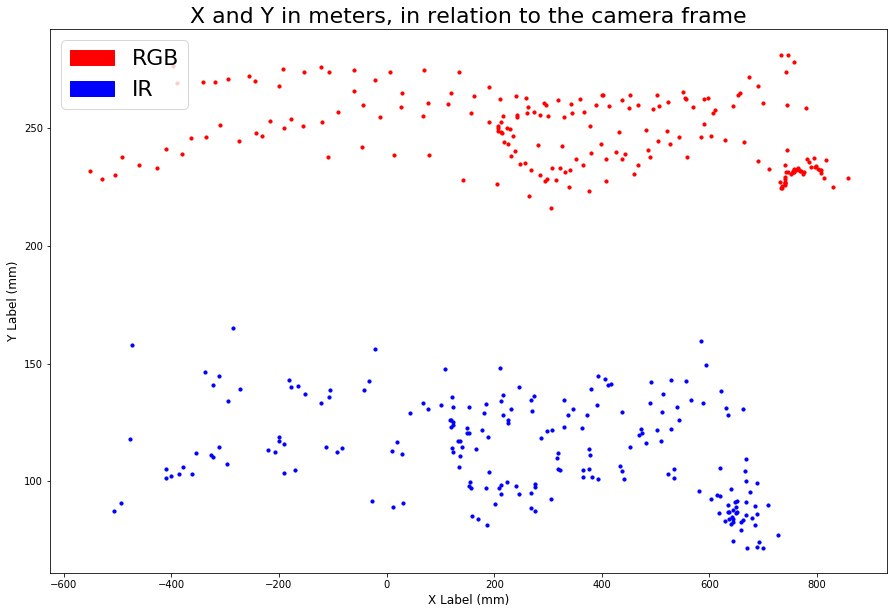

In [35]:
fig0, axs_0 = plt.subplots(1,1,figsize=(15,10))
blue_patch = mpatches.Patch(color='blue', label='IR')
red_patch = mpatches.Patch(color='red', label='RGB')
plt.legend(handles=[red_patch,blue_patch],fontsize=22,loc=2)

# fig0.suptitle("XY projection in meters and in pixels, respectively ")

axs_0.scatter(Xt,Yt,c='b',s=10)
axs_0.scatter(Xm,Ym,c='r',s=10)
axs_0.set_xlabel('X Label (mm)',fontsize=12)
axs_0.set_ylabel('Y Label (mm)',fontsize=12)
axs_0.set_title('X and Y in meters, in relation to the camera frame',fontsize=22)



In [36]:
np.array([Xt,Yt,Xm,Ym])
# np.savetxt('xy_mm.csv',np.array([Xt,Yt,Xm,Ym]),newline='\n',delimiter=' ')
write_file =os.path.join("/home/danielarato/ball_detection/notebooks", "xy_mm.csv")
f = open(write_file, "w")
for i in range(len(Xt)):
    f.write("%f %f %f %f\n"%(Xt[i],Yt[i],Xm[i],Ym[i]))

f.close()
    

<h1>Calculate transformations (from RGB to Thermal) </h1> 

In [37]:
objectPoints2_old=np.array([Xt,Yt,Zt]).T #Termica
objectPoints3=np.array([Xm,Ym,Zm]).T #Mono

objectPoints2=objectPoints2_old[objectPoints2_old[:,2]<80000]
objectPoints3=objectPoints3[objectPoints2_old[:,2]<80000]


# print(objectPoints1.shape,objectPoints2.shape,objectPoints3.shape)
imagePoints1=np.array([xpm,ypm]).T
imagePoints2=np.array([xpi,ypi]).T

In [38]:
def transformation(points, rotation_matrix):
    new_points= np.empty([points.shape[0], 3])
    for n in range(0,points.shape[0]):
        point=np.array([points[n,0],points[n,1],points[n,2],1])
#         new_points[n,0] = rotation_matrix[0,0] * points[n, 0] + rotation_matrix[0,1] * points[n, 1] + rotation_matrix[0,2] * points[n, 2] + rotation_matrix[0,3]
#         new_points[n,1] = rotation_matrix[1,0] * points[n, 0] + rotation_matrix[1,1] * points[n, 1] + rotation_matrix[1,2] * points[n, 2] + rotation_matrix[1,3]
#         new_points[n,2] = rotation_matrix[2,0] * points[n, 0] + rotation_matrix[2,1] * points[n, 1] + rotation_matrix[2,2] * points[n, 2] + rotation_matrix[2,3]
        new_points[n,:]=rotation_matrix[:3,:]@point
    return new_points

In [39]:
def best_fit_transform(A, B):
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=1000, tolerance=0.0001):
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

In [43]:
T_23, distances_23, i=icp(objectPoints2,objectPoints3)
transformed_points_23=transformation(objectPoints2,T_23)
rmse_23=mean_squared_error(transformed_points_23,objectPoints3,squared=False)

T_32, distances_32, i=icp(objectPoints3,objectPoints2)
transformed_points_32=transformation(objectPoints3,T_32)
rmse_32=mean_squared_error(transformed_points_32,objectPoints2,squared=False)

print(T_23,"\n",T_32)

print(rmse_23,"\n",rmse_32)
print(np.mean(distances_23),np.mean(distances_32))

[[ 9.95593502e-01 -3.85375897e-03  9.36948592e-02 -2.18372929e+02]
 [-6.69056887e-04  9.98837843e-01  4.81924945e-02 -1.53943882e+01]
 [-9.37716933e-02 -4.80428215e-02  9.94433888e-01  3.15566382e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 
 [[ 9.94296697e-01 -3.64426452e-03 -1.06587043e-01  3.04606729e+02]
 [-1.20541021e-03  9.98968166e-01 -4.53998862e-02  1.51445998e+01]
 [ 1.06642512e-01  4.52694380e-02  9.93266355e-01 -2.46809608e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
61.67985791182951 
 69.75028406921099
25.71556950806206 31.059224447292863


<h3>Plot transformed cloud and 2D projection in each axis plane</h3>

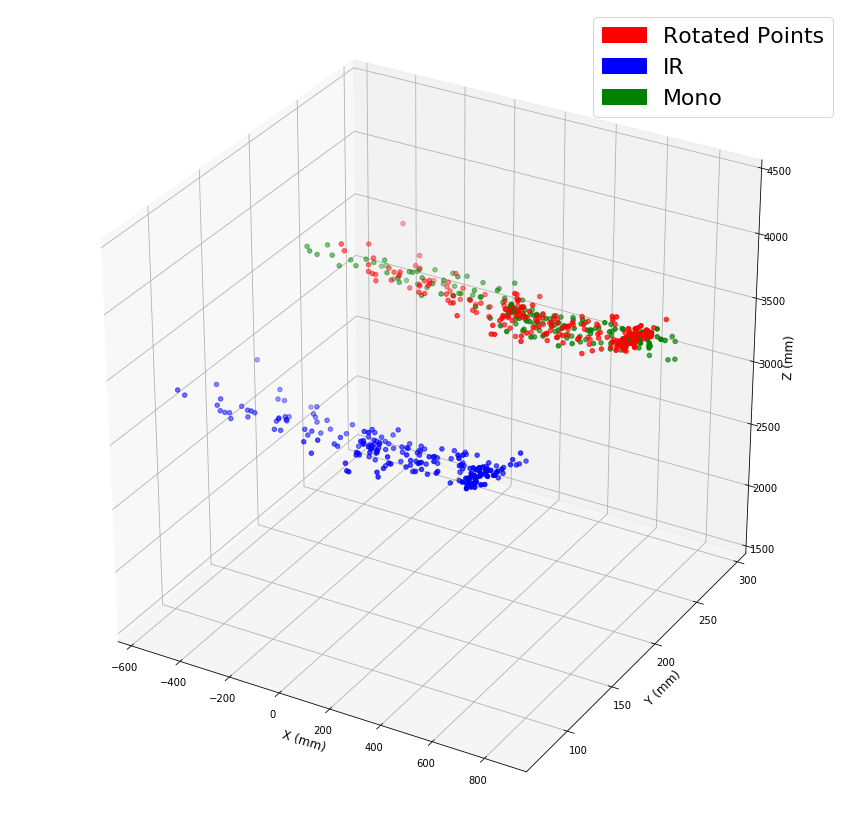

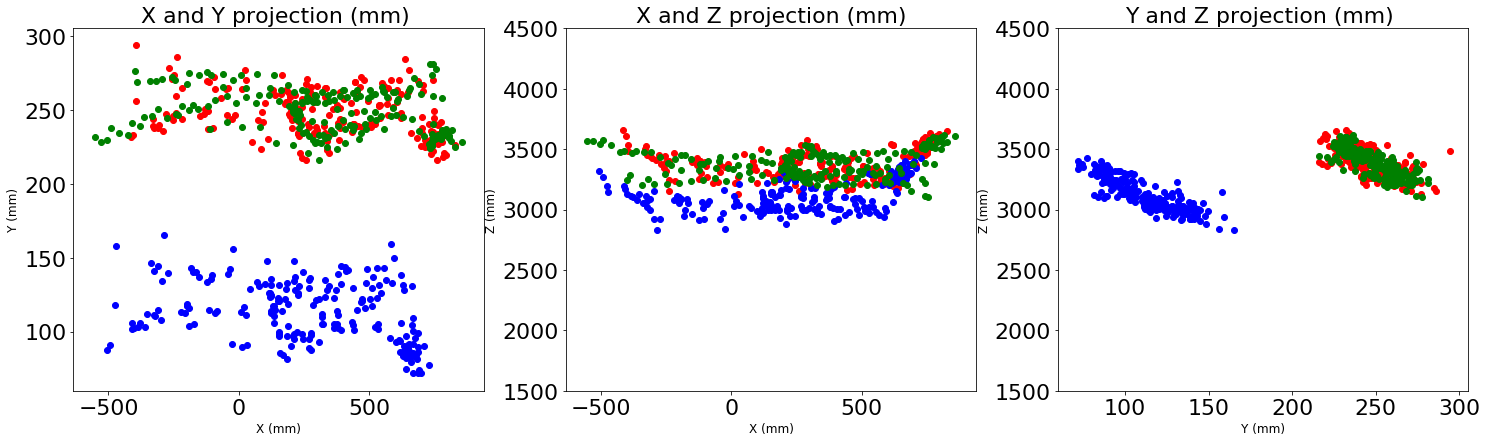

In [41]:
fig2 = plt.figure(figsize=(15,15))
ax2 = fig2.add_subplot(1,1,1, projection='3d')
# fig2.subplots_adjust(wspace=0, hspace=0)
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
# fig2.subplots_adjust(wspace=0, hspace=0)
# fig2.rc('xtick', labelsize=18)    # fontsize of the tick labels
# fig2.rc('ytick', labelsize=18)    # fontsize of the tick labels

red_patch = mpatches.Patch(color='red', label='Rotated Points')
blue_patch = mpatches.Patch(color='blue', label='IR')
black_patch = mpatches.Patch(color='black', label='Mono - objectPoints3')
green_patch = mpatches.Patch(color='green', label='Mono')
yellow_patch = mpatches.Patch(color='yellow', label='Rotated points')
plt.legend(handles=[red_patch,blue_patch,green_patch],fontsize=22)

ax2.set_xlabel('X (mm)',fontsize=12)
ax2.set_ylabel('Y (mm)',fontsize=12)
ax2.set_zlabel('Z (mm)',fontsize=12)
ax2.set_zlim(1500,4500)


ax2.scatter(transformed_points_23[:,0],transformed_points_23[:,1],transformed_points_23[:,2], c='r')
# ax2.scatter(transformed_points_32[:,0],transformed_points_32[:,1],transformed_points_32[:,2], c='y')
ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b') #termica
ax2.scatter(objectPoints3[:,0],objectPoints3[:,1],objectPoints3[:,2], c='g') #mono

fig_final, axs_f = plt.subplots(1,3,figsize=(25,20/3))
# fig_final.legend(handles=[red_patch,blue_patch,green_patch])


axs_f[0].scatter(transformed_points_23[:,0],transformed_points_23[:,1], c='r')
# axs_f[0].scatter(transformed_points_32[:,0],transformed_points_32[:,1], c='y')
axs_f[0].scatter(objectPoints2[:,0],objectPoints2[:,1], c='b') #termica 
axs_f[0].scatter(objectPoints3[:,0],objectPoints3[:,1], c='g') #termica 
axs_f[0].set_xlabel('X (mm)',fontsize=12)
axs_f[0].set_ylabel('Y (mm)',fontsize=12)
axs_f[0].set_title('X and Y projection (mm) ',fontsize=22)


axs_f[1].scatter(transformed_points_23[:,0],transformed_points_23[:,2], c='r')
# axs_f[1].scatter(transformed_points_32[:,0],transformed_points_32[:,2], c='y')
axs_f[1].scatter(objectPoints2[:,0],objectPoints2[:,2], c='b')
axs_f[1].scatter(objectPoints3[:,0],objectPoints3[:,2], c='g')
axs_f[1].set_xlabel('X (mm)',fontsize=12)
axs_f[1].set_ylabel('Z (mm)',fontsize=12)
axs_f[1].set_title('X and Z projection (mm)',fontsize=22)
axs_f[1].set_ylim(1500,4500)

axs_f[2].scatter(transformed_points_23[:,1],transformed_points_23[:,2], c='r')
# axs_f[2].scatter(transformed_points_32[:,1],transformed_points_32[:,2], c='y')
axs_f[2].scatter(objectPoints2[:,1],objectPoints2[:,2], c='b')
axs_f[2].scatter(objectPoints3[:,1],objectPoints3[:,2], c='g')
axs_f[2].set_xlabel('Y (mm)',fontsize=12)
axs_f[2].set_ylabel('Z (mm)',fontsize=12)
axs_f[2].set_title('Y and Z projection (mm) ',fontsize=22)
axs_f[2].set_ylim(1500,4500)



plt.show()

<h1>Calculate transformations (from Thermal to RGB) </h1> 

In [ ]:
write_file =os.path.join("/home/danielarato/ball_detection/notebooks", "compilation.csv")
f = open(write_file, "w")
for i in range(len(Xt)):
    f.write("%f %f %f %f %f %f %f %f %f\n"%(objectPoints2[i,0],objectPoints2[i,1],objectPoints2[i,2],objectPoints3[i,0],objectPoints3[i,1],objectPoints3[i,2],transformed_points_23[i,0],transformed_points_23[i,1],transformed_points_23[i,2]))

f.close()
    

In [ ]:
fig2 = plt.figure(figsize=(15,15))
ax2 = fig2.add_subplot(111, projection='3d')

red_patch = mpatches.Patch(color='red', label='Rotated points')
green_patch = mpatches.Patch(color='green', label='Dest points - RGB')
blue_patch = mpatches.Patch(color='blue', label='Source points - IR')
plt.legend(handles=[red_patch,blue_patch,green_patch])

ax2.set_xlabel('X Label (mm)')
ax2.set_ylabel('Y Label (mm)')
ax2.set_zlabel('Target distance to the camera (mm)')

ax2.scatter(transformed_points_trgb[:,0],transformed_points_trgb[:,1],transformed_points_trgb[:,2], c='r')
ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='g')
ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b')

fig_final, axs_f = plt.subplots(1,3,figsize=(20,5))

axs_f[0].scatter(transformed_points_trgb[:,0],transformed_points_trgb[:,1], c='r')
axs_f[0].scatter(objectPoints1[:,0],objectPoints1[:,1], c='g')
axs_f[0].scatter(objectPoints2[:,0],objectPoints2[:,1], c='b')
axs_f[0].set_xlabel('X Label (mm)')
axs_f[0].set_ylabel('Y Label (mm)')
axs_f[0].set_title('X and Y projection (mm)')

axs_f[1].scatter(transformed_points_trgb[:,0],transformed_points_trgb[:,2], c='r')
axs_f[1].scatter(objectPoints1[:,0],objectPoints1[:,2], c='g')
axs_f[1].scatter(objectPoints2[:,0],objectPoints2[:,2], c='b')
axs_f[1].set_xlabel('X Label(mm)')
axs_f[1].set_ylabel('Z Label (mm)')
axs_f[1].set_title('X and Z projection (mm)')

axs_f[2].scatter(transformed_points_trgb[:,1],transformed_points_trgb[:,2], c='r')
axs_f[2].scatter(objectPoints1[:,1],objectPoints1[:,2], c='g')
axs_f[2].scatter(objectPoints2[:,1],objectPoints2[:,2], c='b')
axs_f[2].set_xlabel('Y Label(mm)')
axs_f[2].set_ylabel('Z Label (mm)')
axs_f[2].set_title('Y and Z projection (mm)')

plt.show()